In [53]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels import robust

total_particle_number = 1.0e8
PMass = 32051887299076.293 / 1.989e33 # solar masses
Mtot = PMass * total_particle_number
MassPerPart = PMass

def load_data(PATH, time_step, num_files):
# Loads in the data from the .particles and .ascii files at a particular output redshift/scale factor. It loads
# the data into a particle_data and an ascii_data array which are then returned
    for i in range(num_files):
        print('Loading File ' + str(i))
        if i == 0:
            particle_data=np.loadtxt(PATH + 'halos_' + str(time_step) + '.' +\
                                     str(i) + '.particles',
                                     dtype=float, delimiter=' ', comments=['#', '&'])
            ascii_data   =np.loadtxt(PATH + 'halos_' + str(time_step) + '.' + str(i) + '.ascii',
                                     dtype=float, delimiter=' ', comments='#')
        else:
            particle_data_new = np.loadtxt(PATH + 'halos_' + str(time_step) +\
                                           '.' + str(i) + '.particles',
                                           dtype=float, delimiter=' ', comments=['#', '&'])
            ascii_data_new    = np.loadtxt(PATH + 'halos_' + str(time_step) +\
                                           '.' + str(i) + '.ascii',
                                           dtype=float, delimiter=' ', comments='#')
            particle_data = np.concatenate((particle_data, particle_data_new), axis=0)
            ascii_data    = np.concatenate((ascii_data, ascii_data_new), axis=0)

    print("Data Loaded...")
    return particle_data, ascii_data;

def parse_halos(ascii_data):
# gets the number of halos in each of the halos by looking at the ascii data files about each halo
    halo_nums = ascii_data[:, 1]
    halo_breaks = np.empty(np.size(halo_nums) + 1)
    for i in range(np.size(halo_breaks)):
        halo_breaks[i] = np.sum(halo_nums[:i])
    return halo_breaks;

def get_halo_position(particle_positions):
# gets the center of mass of the halo by calculating the mean position in the x, y, and z directions
# and assuming all of the particles have a constant mass
    x = np.mean(particle_positions[:, 0])
    y = np.mean(particle_positions[:, 1])
    z = np.mean(particle_positions[:, 2])
    return np.array([x, y, z]);

def get_separations(particle_positions, halo_position):
# gets the separation of each particle from the center. This will then tell you what fraction are within
# a certain radius
    separations = np.zeros(np.shape(particle_positions)[0])
    for i in range(np.shape(particle_positions)[0]):
        separations[i] = np.linalg.norm(particle_positions[i, :] - halo_position)
    return separations;

def make_histogram(array, Nbins):
# makes a histogram of the data. This is a useless function
    hist, bins = np.histogram(array, bins=np.logspace(np.log10(np.min(array)),
                            np.log10(np.max(array)),Nbins))
    return hist, bins;

def hmf(hist, bins):
# this gets the actually useful quantities for the HMF including dn_dlogM and the errors in these measurements
# the errors are currently calculated using sqrt(N) approximation. This is going to be changed later on.
    dn_dlogM  = np.zeros(np.shape(hist))
    df_dlogM  = np.zeros(np.shape(hist))
    masses    = np.zeros(np.shape(hist))
    errors_dn = np.zeros(np.shape(hist))
    errors_df = np.zeros(np.shape(hist))
    for i in range(len(hist)):
        dlogM = (np.log10(bins[i+1]) - np.log10(bins[i]))
        dn_dlogM[i] = hist[i] / dlogM
        masses[i] = 0.5 * (bins[i+1] + bins[i])
        df_dlogM[i] = masses[i] * dn_dlogM[i] / Mtot
        errors_dn[i] = np.sqrt(hist[i]) / dlogM
        errors_df[i] = masses[i] * errors_dn[i] / Mtot
    
    return masses, dn_dlogM, errors_dn, df_dlogM, errors_df;

def get_density_profile(particle_data, ascii_data, halo_breaks, halo_id, N):
# The radial density profile for the given halo is caluclated using the fraction of the particles (and thereby
# the fraction of the mass) contained within a particular radius.
    # get data for the halo you chose
    break1 = int(halo_breaks[halo_id])
    break2 = int(halo_breaks[halo_id + 1])
    halo_particles = particle_data[break1:break2, 0:3]
    halo_position  = get_halo_position(halo_particles)
    displacements  = get_separations(halo_particles, halo_position)
    if len(displacements) == 0:
        return np.zeros(N), np.zeros(N), 0.0, 0.0, 0.0;
    radius = np.max(displacements)
    half_mass_radius = ascii_data[halo_id, 48]
    
    fractions = np.linspace(0.1, 1.0, N)
    radial_fractions = fractions * radius 
    # gives an array of 10%, 20%, ..., 90%, 100% of the halo radius
    radial_counts = np.zeros(N)
    for i in range(0, N):
        counts = 0
        for j in range(len(displacements)):
            if displacements[j] <= radial_fractions[i]:
                counts += 1
        radial_counts[i] = counts
    densities = radial_counts * MassPerPart / (4 * np.pi * radial_fractions**3 / 3)
    std_density = np.sqrt(radial_counts) * MassPerPart / (4 * np.pi * radial_fractions**3 / 3)
    normalized_counts = radial_counts / len(displacements)
    
    return radial_fractions, densities, radial_counts, radius, std_density;

In [2]:
# Load in the data for file number "time" and load in the first "N" files corresponding to that redshift
PATH = '/scratch/bsafdi_root/bsafdi/wentmich/halos/'
time, N = 45, 8
particle_data, ascii_data = load_data(PATH, time, N)

Loading File 0
Loading File 1
Loading File 2
Loading File 3
Loading File 4
Loading File 5
Loading File 6
Loading File 7
Data Loaded...


In [3]:
print(np.shape(particle_data))
count = 0
for i in range(np.shape(particle_data)[0]):
    if particle_data[i, -2] != particle_data[i, -3]:
        count += 1
print('Count = ' + str(count))
zero_ids = []
for i in range(np.shape(ascii_data)[0]):
    if ascii_data[i, 1] < 20:
        zero_ids.append(ascii_data[i, 0])
print(len(zero_ids))

(190063486, 10)
Count = 121208164
1356


In [4]:
halo_breaks = parse_halos(ascii_data)
print('halos broken down...')

halos broken down...


Halos counted...
Total number of halos = 106200
Halos histogrammed...


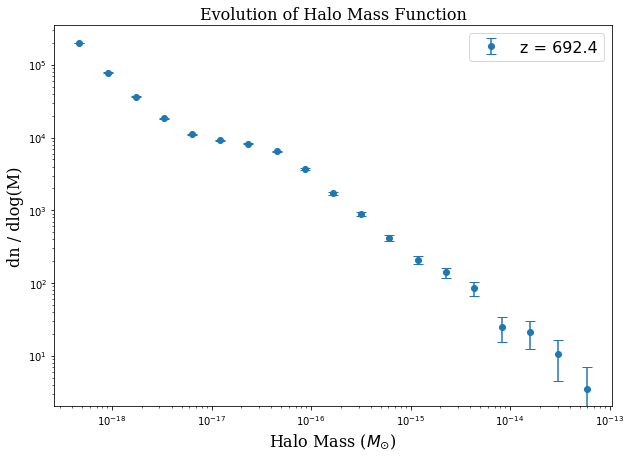

In [5]:
Nbins = 20 # number of bins in the histogram w.r.t. the halo masses
Nmin = 20 # minimum number of particles per halo

# This bit gets rid of any halos that have fewer than Nmin particles.
halo_counts = ascii_data[:, 1]
i = 0
while i < len(halo_counts):
    if halo_counts[i] < Nmin:
        halo_counts = np.delete(halo_counts, i)
    else:
        i += 1
print('Halos counted...')

Nhalos = np.size(halo_counts)
print('Total number of halos = ' + str(Nhalos))

# Now we histogram the halos according to their masses and create a HMF using the histogram
histogram, bins = make_histogram(halo_counts * PMass, Nbins)
masses, dn_dlogM, errors_dn, df_dlogM, errors_df = hmf(histogram, bins)
print('Halos histogrammed...')

# Plots the HMF from above
plt.figure(figsize=(10, 7))
plt.errorbar(masses, dn_dlogM, yerr=errors_dn, fmt='o', capsize=5, label='z = %.01f' % 692.4)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'Halo Mass ($M_{\odot}$)', fontsize=16, fontname='serif')
plt.ylabel(r'dn / dlog(M)', fontsize=16, fontname='serif')
plt.title(r'Evolution of Halo Mass Function', fontsize=16, fontname='serif')
plt.legend(fontsize=16)
plt.show()

In [6]:
sorted_halo_counts = sorted(list(halo_counts))
print(np.array(sorted_halo_counts))

[2.000000e+01 2.000000e+01 2.000000e+01 ... 1.727850e+06 2.191901e+06
 4.805258e+06]


In [54]:
# This is the new stuff. The idea is to calculate the density profile for each of the halos that have so far
# been loaded in. 
masses_central_densities_central_counts = np.zeros([3, Nhalos])
zeros = 0
for i in range(np.shape(ascii_data)[0]):
    if ascii_data[i, 1] >= Nmin:
        halo_mass = ascii_data[i, 1] * PMass
        results = get_density_profile(particle_data, ascii_data, halo_breaks, i, 10)
        densities = results[1]
        radial_counts = results[2]
        masses_central_densities_central_counts[0, i - zeros] = halo_mass
        masses_central_densities_central_counts[1, i - zeros] = densities[0]
        masses_central_densities_central_counts[2, i - zeros] = radial_counts[0]
    else:
        zeros += 1
    if i%100000 == 0:
        print('Done with halo ' + str(i))
print('Central densities found...')

Done with halo 0
Done with halo 100000
Central densities found...


In [56]:
print(masses_central_densities_central_counts[1, :])
print(masses_central_densities_central_counts[2, :])

[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 7.33796708e+11
 4.82407353e+11 5.08134514e+11]
[0. 0. 0. ... 6. 5. 2.]


7.743468469531661e-14
3.222914761093644e-19
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 7.33796708e+11
 4.82407353e+11 5.08134514e+11]


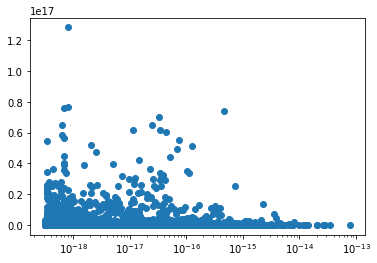

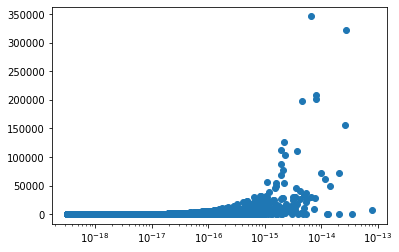

106200


In [57]:
print(np.max(masses_central_densities_central_counts[0, :]))
print(np.min(masses_central_densities_central_counts[0, :]))
print(masses_central_densities_central_counts[1, :])
plt.plot(masses_central_densities_central_counts[0, :], masses_central_densities_central_counts[1, :], 'o')
plt.xscale('log')
plt.show()

plt.plot(masses_central_densities_central_counts[0, :], masses_central_densities_central_counts[2, :], 'o')
plt.xscale('log')
plt.show()

print(np.shape(masses_and_central_densities)[1])

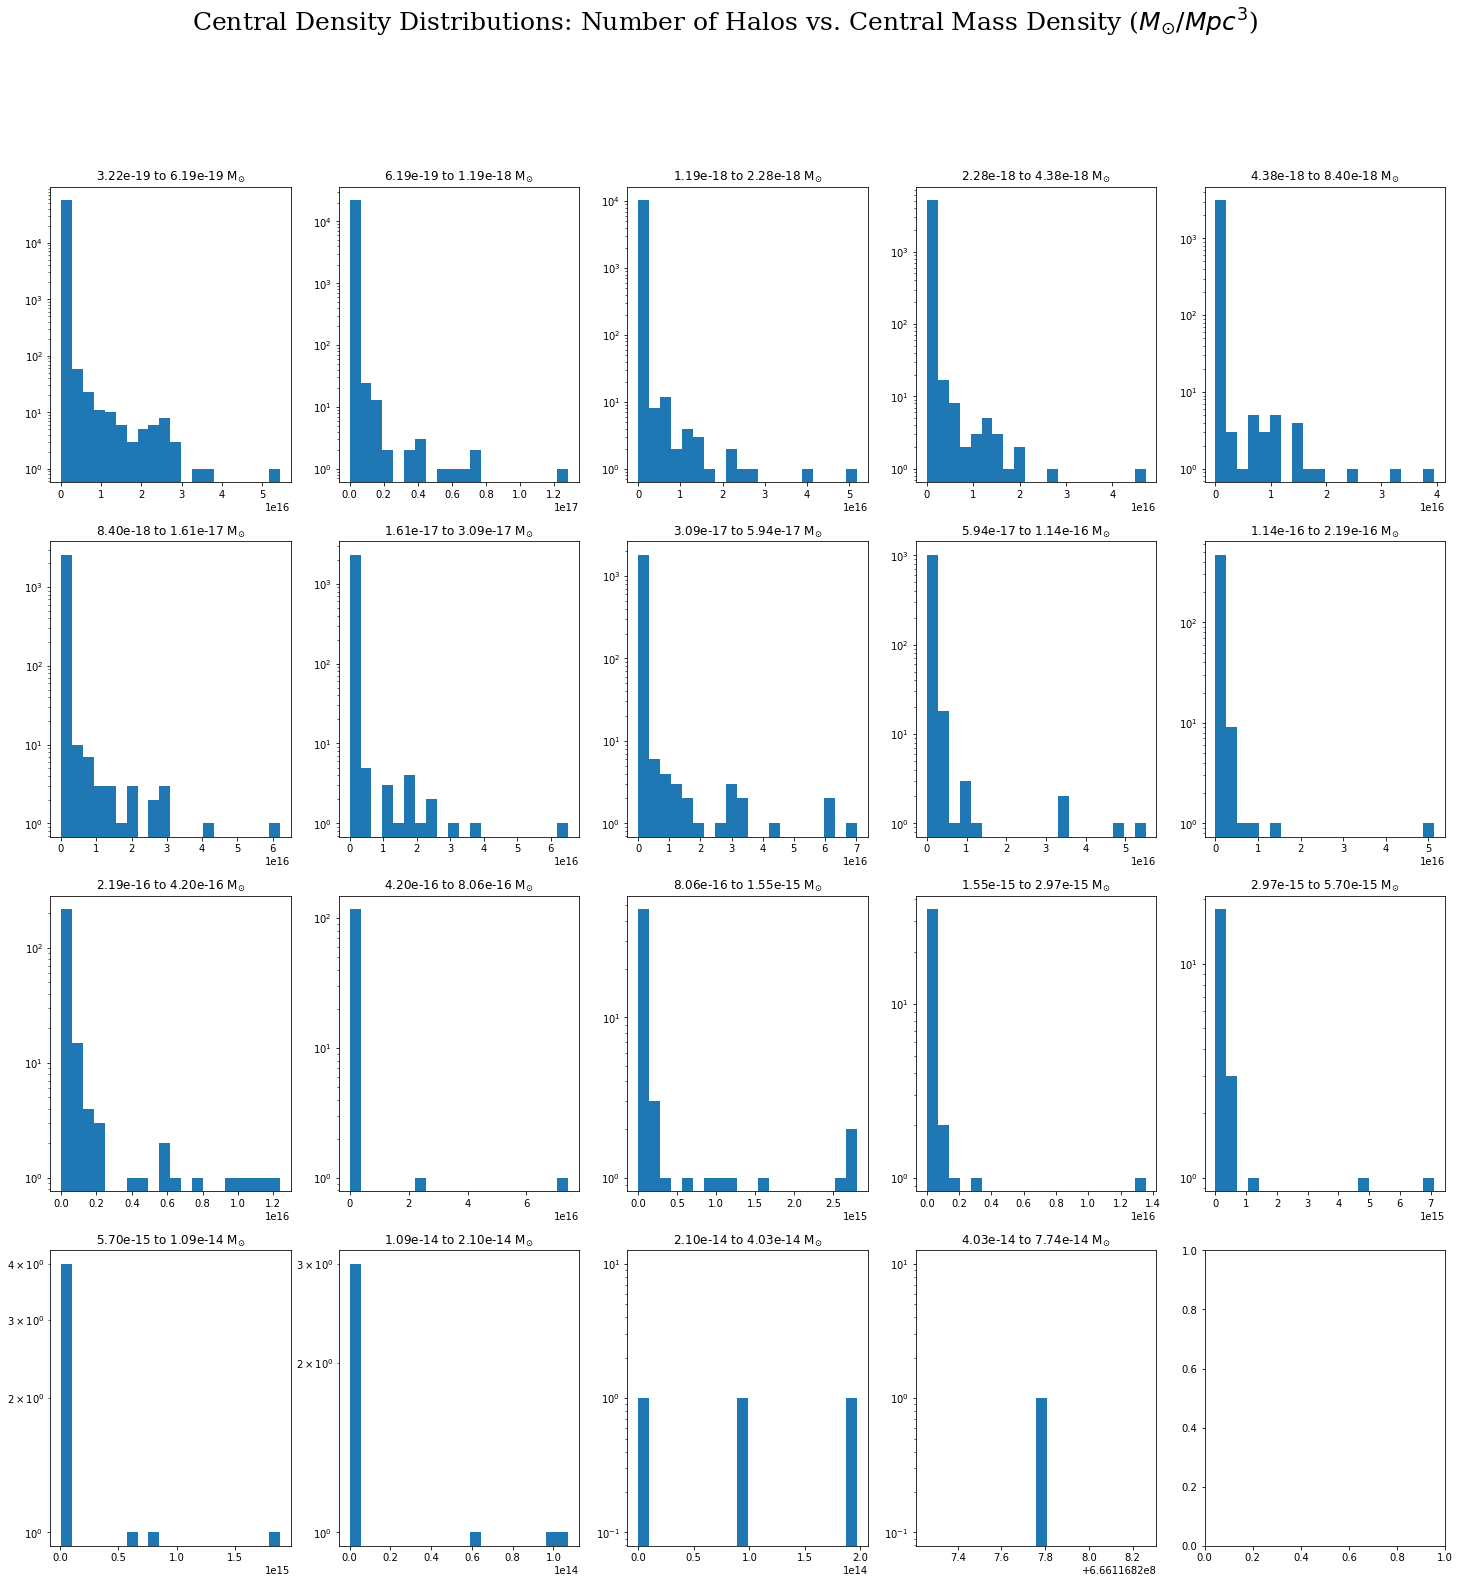

In [77]:
# we need to make to histogram the masses and then separate the central densities in terms of this mass histogram
average_central_densities = np.empty(Nbins - 1)
median_central_densities = np.empty(Nbins - 1)
std_central_densities = np.empty(Nbins - 1)
mad_central_densities = np.empty(Nbins - 1)

average_central_counts = np.empty(Nbins - 1)
median_central_counts = np.empty(Nbins - 1)
std_central_counts = np.empty(Nbins - 1)
mad_central_counts = np.empty(Nbins - 1)

fig, ax = plt.subplots(4, 5, figsize=(25, 25))

xcount = 0
ycount = 0
for i in range(Nbins - 1):
    if i != 0 and i % 5 == 0:
        ycount += 1
    central_densities = []
    for j in range(np.shape(masses_central_densities_central_counts)[1]):
        if masses_central_densities_central_counts[0, j] < bins[i + 1] and masses_central_densities_central_counts[0, j] > bins[i]:
            central_densities.append(masses_central_densities_central_counts[1, j])
            
    central_densities = np.array(central_densities)
    
    ax[ycount, xcount].hist(central_densities, bins=20)
    #ax[ycount, xcount].set_title(str(bins[i]) + ' to ' + str(bins[i + 1]) + r' M$_{\odot}$')
    ax[ycount, xcount].set_title('{:.2e}'.format(bins[i], "e") + ' to ' + '{:.2e}'.format(bins[i + 1], "e") + r' M$_{\odot}$')
    ax[ycount, xcount].set_yscale('log')
    #ax[i%4, i%5].set_xscale('log')
    #ax[i%4, i%5].set_ylabel('Frequency')
    #ax[i%4, i%5].set_xlabel('Central Density')

    average_central_densities[i] = np.mean(np.array(central_densities))
    median_central_densities[i] = np.median(np.array(central_densities))
    std_central_densities[i] = np.std(np.array(central_densities))
    mad_central_densities[i] = robust.mad(np.array(central_densities))

    xcount += 1
    xcount = xcount % 5
    ycount = ycount % 4
    
#ax.set_title('Central Density Distribution')
#ax.set_ylabel('Counts')
#ax.set_xlabel('Halo Central Density')
fig.suptitle(r'Central Density Distributions: Number of Halos vs. Central Mass Density ($M_{\odot} / Mpc^3$)', fontsize=25, fontname='serif')
plt.savefig('central_mass_density_distributions.png', dpi=1000)
plt.show()

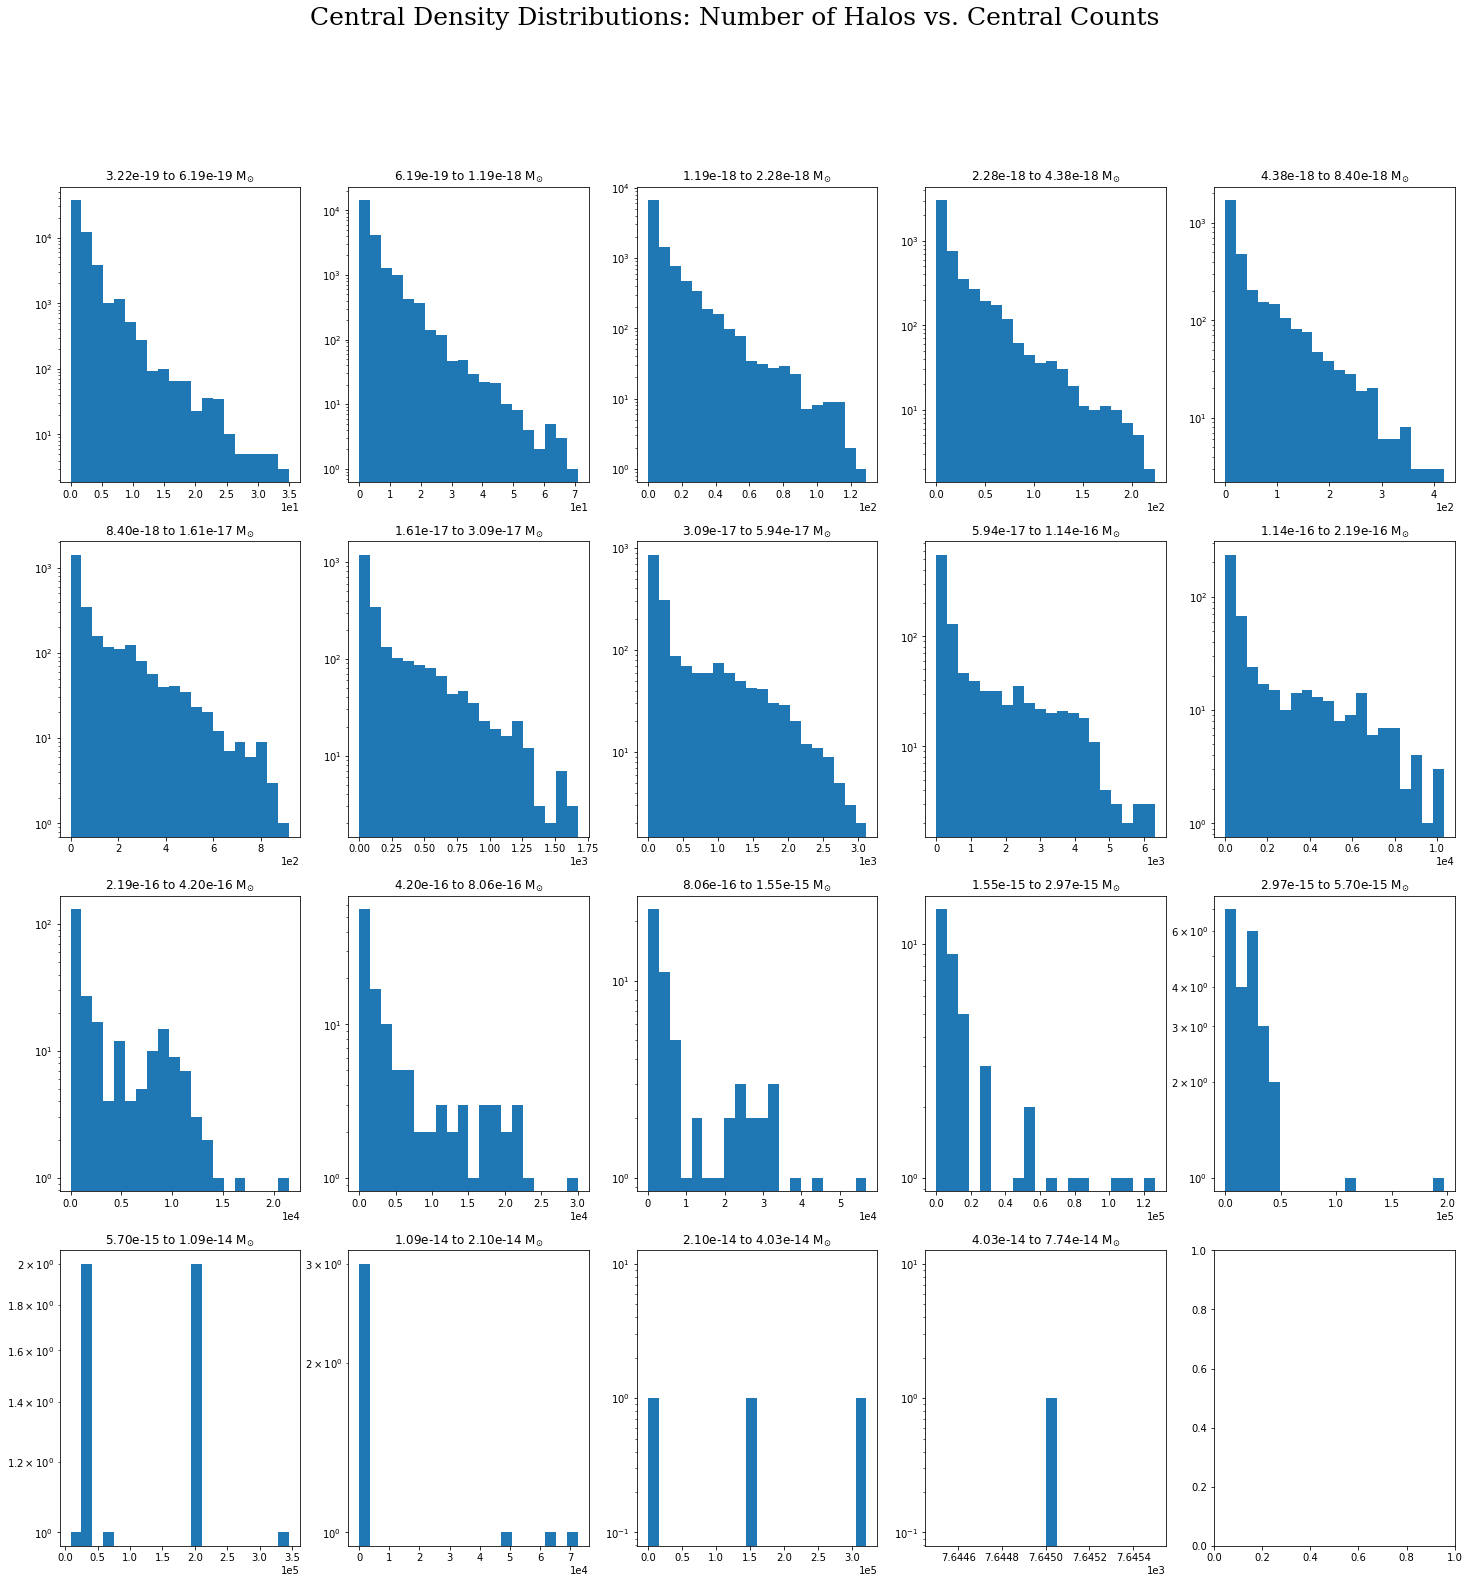

In [64]:
average_central_counts = np.empty(Nbins - 1)
median_central_counts = np.empty(Nbins - 1)
std_central_counts = np.empty(Nbins - 1)
mad_central_counts = np.empty(Nbins - 1)

fig, ax = plt.subplots(4, 5, figsize=(25, 25))

xcount = 0
ycount = 0
for i in range(Nbins - 1):
    if i != 0 and i % 5 == 0:
        ycount += 1
    central_counts = []
    for j in range(np.shape(masses_central_densities_central_counts)[1]):
        if masses_central_densities_central_counts[0, j] < bins[i + 1] and masses_central_densities_central_counts[0, j] > bins[i]:
            central_counts.append(masses_central_densities_central_counts[2, j])
            
    central_counts = np.array(central_counts)
    
    ax[ycount, xcount].hist(central_counts, bins=20)
    ax[ycount, xcount].set_title('{:.2e}'.format(bins[i], "e") + ' to ' + '{:.2e}'.format(bins[i + 1], "e") + r' M$_{\odot}$')
    ax[ycount, xcount].set_yscale('log')
    ax[ycount, xcount].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    
    xcount += 1
    xcount = xcount % 5
    ycount = ycount % 4

fig.suptitle('Central Density Distributions: Number of Halos vs. Central Counts', fontsize=25, fontname='serif')
plt.savefig('central_counts_distributions.png', dpi=1000)
plt.show()

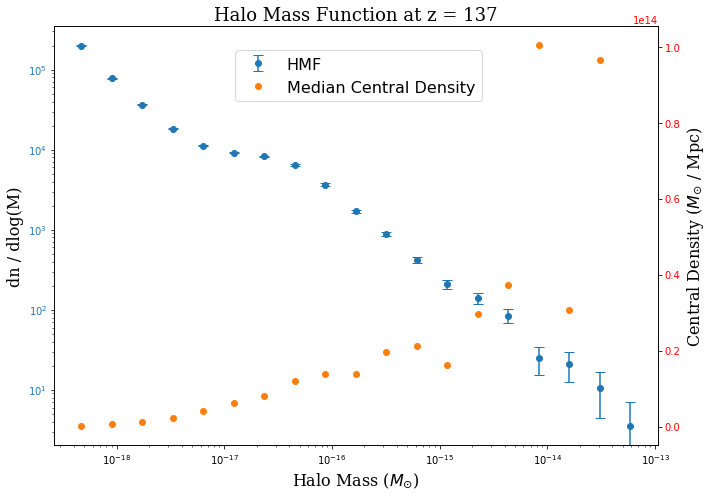

In [76]:
fig, ax1 = plt.subplots(figsize=(10, 7))

color = 'tab:blue'
ax1.set_xlabel(r'Halo Mass ($M_{\odot}$)', fontsize=16, fontname='serif')
ax1.set_ylabel(r'dn / dlog(M)', fontsize=16, fontname='serif')
ax1.errorbar(masses, dn_dlogM, yerr=errors_dn, fmt='o', color='C0', capsize=5, label='HMF')
ax1.tick_params(axis='y', labelcolor='C0')
ax1.set_xscale('log')
ax1.set_yscale('log')
#ax1.set_xticklabels(fontsize=16)

color = 'tab:red'
ax2 = ax1.twinx()
ax2.set_ylabel(r'Central Density ($M_{\odot}$ / Mpc)', fontsize=16, fontname='serif')
#ax2.errorbar(masses, median_central_densities, yerr=mad_central_densities, fmt='o',
#             color='C1', capsize=5, label='Median Central Density')
#ax2.errorbar(masses, average_central_densities, yerr=std_central_densities, fmt='o',
#             color='C2', capsize=5, label='Mean Central Density')
ax2.plot(masses[:-1], median_central_densities[:-1], 'o',
             color='C1', label='Median Central Density')
#ax2.plot(masses[:-1], average_central_densities[:-1], 'o',
#             color='C2', label='Mean Central Density')
ax2.tick_params(axis='y', labelcolor='red')

#plt.legend(fontsize=16)
fig.tight_layout(rect=[0, 0.03, 0.9, 0.9])
plt.title('Halo Mass Function at z = 137', fontsize=18, fontname='serif')
fig.legend(fontsize=16, bbox_to_anchor=(0.25, 0.4, 0.43, 0.5))
fig.tight_layout()
plt.savefig('hmf_central_density.png', dpi=1000)
plt.show()

In [ ]:
## Redshift z = 137